In [6]:
import os
import sys

import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
import pickle
from scipy.stats import norm

from utils import compare
from envs import SingleSmallPeakEnv, DiscreteBanditEnv

In [2]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [3]:
env = SingleSmallPeakEnv(noise_std=0.1)
data_gaussian = compare(env, 'gaussian', n_steps=100, repeats=20,
               lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)
data_gaussian['mean'] = data_gaussian['pd_param_0_mean']
data_gaussian['std'] = data_gaussian['pd_param_1_mean']
with open('single_peak_gaussian.pkl', 'wb') as f:
    pickle.dump(data_gaussian, f)

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env = SingleSmallPeakEnv(noise_std=0.1)
data_beta = compare(env, 'beta', n_steps=100, repeats=20,
                    lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)

a = data_beta['pd_param_0_mean']
b = data_beta['pd_param_1_mean']
data_beta['mean'] = a / (a + b)
data_beta['std'] = (a * b / (a + b + 1)).apply(np.sqrt) / (a + b)
# Scale it to the action space
low = env.action_space.low
high = env.action_space.high
data_beta['mean'] = data_beta['mean'] * (high-low) + low
data_beta['std'] = data_beta['std'] * (high-low)
with open('single_peak_beta.pkl', 'wb') as f:
    pickle.dump(data_beta, f)

In [7]:
# Discretize in intervals of 0.1 between -1.5 and 1.5
# two high reward blocks in -1.0 - -0.8
avg_rewards = 0.1 * np.random.randn(30)
avg_rewards[:2] = 1.0
env = DiscreteBanditEnv(avg_rewards=avg_rewards)
data_discrete = compare(env, 'discrete', n_steps=100, repeats=20,
                        lr=1e-1, batch_size=16*32, num_minibatches=16, ppo_epochs=10)
with open('single_peak_discrete.pkl', 'wb') as f:
    pickle.dump(data_discrete, f)

In [12]:
with open('single_peak_gaussian.pkl', 'rb') as f:
    data_gaussian = pickle.load(f)
with open('single_peak_beta.pkl', 'rb') as f:
    data_beta = pickle.load(f)    
with open('single_peak_discrete.pkl', 'rb') as f:
    data_discrete = pickle.load(f) 

In [15]:
%matplotlib inline

# Figure 1

## For clearity in visualization, we only plot the first run in Figure 1, but the failure mode happens consistently in many runs. The exact visualization of each failure run is different, but they all have the same failure mode pattern of the mean drifting away.

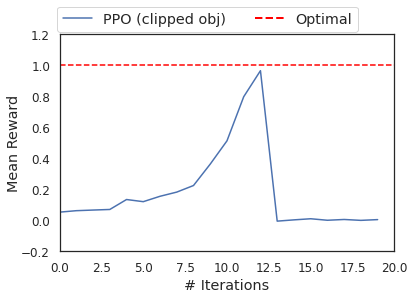

In [16]:
sns.set(style='white', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

niters = 20
data = filter_df(data_gaussian, method='Clipping').iloc[:niters]
fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
sns.lineplot(data=data, x='iter', y='mean_reward', hue='method', ax=axes, n_boot=1000)
axes.set_ylabel('Mean Reward', labelpad=0)
axes.set_xlim([0, niters])
axes.set_ylim([-0.2, 1.2])
axes.set_xlabel('# Iterations')
from matplotlib.lines import Line2D
axes.hlines(1.0, 0, 20, colors='red', linestyles='dashed')
redline = Line2D([0], [0], color='red', ls='dashed', lw=2)
#blueine = Line2D([0], [0], color='darkblue', lw=1)
handles, labels = axes.get_legend_handles_labels()
handles=[handles[1], redline]
labels=['PPO (clipped obj)','Optimal']
axes.get_legend().remove()
fig.legend(handles, labels, ncol=2, loc='upper center')
plt.show()

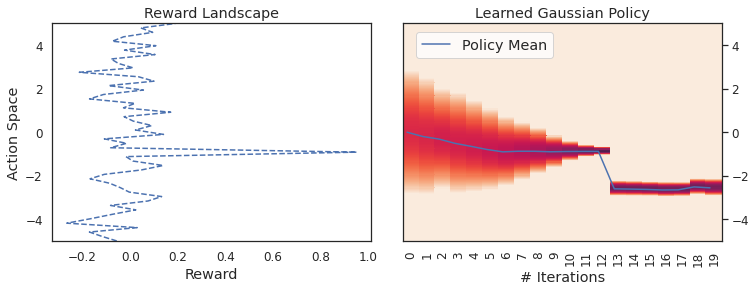

In [20]:
def reward_scalar(x):
    if x > -1.0 and x < -0.8:
        return 1.0 + 0.1 * np.random.randn()
    return 0.1 * np.random.randn()

reward = np.vectorize(reward_scalar)


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
y1 = -5
y2 = 5
niters = 20
nbins = 201
x = np.linspace(y1, y2, 50)
axes[0].set_ylim([y1, y2])
axes[0].set_ylabel('Action Space')
axes[0].set_title('Reward Landscape')
axes[0].set_xlabel('Reward')
axes[0].plot(reward(x), x,
             linestyle='--', label='Reward function', alpha=1)
axes[1].set_ylim([y1, y2])
ax1_twin = axes[1].twinx()
ax1_twin.set_ylim([y1, y2])
x = np.linspace(y1, y2, nbins)
binwidth = (x[1]-x[0])
heatmap = np.zeros((niters, nbins))
for i in range(niters):
    mean = data[data.iter == i]['mean'].values.item()
    std = data[data.iter == i]['std'].values.item()
    rv = norm(loc=mean, scale=std)
    heatmap[i, :] = np.log(1e-6 + rv.cdf(x + binwidth/2) - rv.cdf(x - binwidth/2))
#yticklabels = [xx.round(2) if i % 5 == 0 else ''  for i, xx in enumerate(x)]
sns.heatmap(np.flip(heatmap.T, axis=0), ax=axes[1], square=False, cmap=sns.cm.rocket_r, vmin=-8, vmax=1.0,
            cbar=False, annot=False)
ax1_twin.plot(data[data.iter < niters].iter + 0.25,
              data[data.iter < niters]['mean'], label='Policy Mean')
#ax1_twin.hlines(2.5, 0, 20, color='black')
axes[1].get_yaxis().set_ticks([])
axes[1].set_title('Learned Gaussian Policy')
axes[1].set_xlabel('# Iterations')


fig.align_ylabels(axes)
fig.subplots_adjust(wspace=0.1)
handles, labels = ax1_twin.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.55, 0.8), ncol=3)
plt.show()

# Figure 8

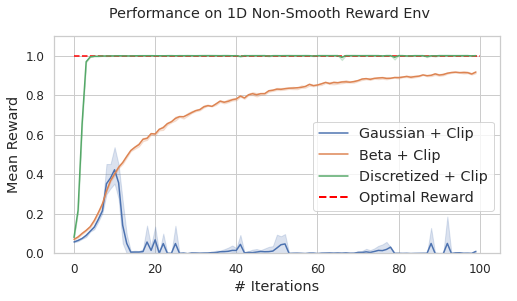

In [22]:
sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})


n_boot = 10

data_gaussian_clip = filter_df(data_gaussian, method='Clipping')
data_beta = filter_df(data_beta, method='Clipping')
data_discrete = filter_df(data_discrete, method='Clipping')
data_gaussian_kl_rev = filter_df(data_gaussian, method='Reverse KL')
data_gaussian_kl_for = filter_df(data_gaussian, method='Forward KL')

fig, axes = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey='row')
sns.lineplot(data=data_gaussian_clip, x='iter', y='mean_reward', ax=axes, n_boot=n_boot,
            label='Gaussian + Clip')
sns.lineplot(data=data_beta, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
            label='Beta + Clip')
sns.lineplot(data=data_discrete, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
            label='Discretized + Clip')
sns.lineplot(data=data_gaussian_kl_rev, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
            label='Gaussian + KL')
#sns.lineplot(data=data_kl_for, x='iter', y='mean_reward',ax=axes, n_boot=n_boot,
#            label='Gaussian + Forward KL')
axes.set_ylabel('Mean Reward')
handles, labels = axes.get_legend_handles_labels()
axes.get_legend().remove()
axes.set_xlabel('# Iterations')
axes.set_ylim([0, 1.1])

from matplotlib.lines import Line2D
axes.hlines(1.0, 0, 100, colors='red', linestyles='dashed')
redline = Line2D([0], [0], color='red', ls='dashed', lw=2, label='Optimal Reward')
fig.align_ylabels(axes)
fig.legend(handles + [redline], labels+['Optimal Reward'],
           loc=(0.605,0.3), ncol=1)

fig.suptitle('Performance on 1D Non-Smooth Reward Env')
plt.show()